In [12]:
import random

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.utils as vutils
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torch import nn
from torch import optim

based on [https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html#loss-functions-and-optimizers](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html#loss-functions-and-optimizers)

In [16]:
BATCH_SIZE = 8
IMG_SZIE = (64, 64)
IMG_CHANNELS = 3
LATENT_SPACE_DIM = 100
GENERATOR_FEATURES_SIZE = 64
DISCRIMINATOR_FEATURES_SIZE = 64
LEARNING_RATE = 0.0002
# Beta1 for Adam
BETA1 = 0.5
NUM_EPOCHS = 1
manualSeed = 999
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Random Seed:  999


In [3]:
dataset = datasets.ImageFolder("lsun_bedroom", transform=transforms.Compose([
    transforms.Resize(IMG_SZIE),
    transforms.CenterCrop(IMG_SZIE),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]))
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
len(dataset), len(loader)

(538725, 67341)

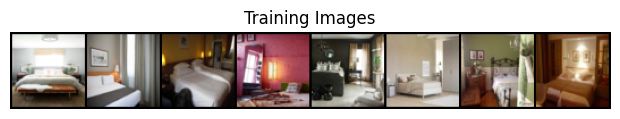

In [4]:
batch = next(iter(loader))
plt.figure(figsize=(8,1))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(batch[0].to(device)[:8], padding=2, normalize=True).cpu(),(1,2,0)))

In [11]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( LATENT_SPACE_DIM, GENERATOR_FEATURES_SIZE * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(GENERATOR_FEATURES_SIZE * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(GENERATOR_FEATURES_SIZE * 8, GENERATOR_FEATURES_SIZE * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(GENERATOR_FEATURES_SIZE * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( GENERATOR_FEATURES_SIZE * 4, GENERATOR_FEATURES_SIZE * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(GENERATOR_FEATURES_SIZE * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( GENERATOR_FEATURES_SIZE * 2, GENERATOR_FEATURES_SIZE, 4, 2, 1, bias=False),
            nn.BatchNorm2d(GENERATOR_FEATURES_SIZE),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d( GENERATOR_FEATURES_SIZE, IMG_CHANNELS, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(IMG_CHANNELS, DISCRIMINATOR_FEATURES_SIZE, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(DISCRIMINATOR_FEATURES_SIZE, DISCRIMINATOR_FEATURES_SIZE * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(DISCRIMINATOR_FEATURES_SIZE * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(DISCRIMINATOR_FEATURES_SIZE * 2, DISCRIMINATOR_FEATURES_SIZE * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(DISCRIMINATOR_FEATURES_SIZE * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(DISCRIMINATOR_FEATURES_SIZE * 4, DISCRIMINATOR_FEATURES_SIZE * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(DISCRIMINATOR_FEATURES_SIZE * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(DISCRIMINATOR_FEATURES_SIZE * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

netG = Generator().to(device)
netD = Discriminator().to(device)


# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG.apply(weights_init)
netD.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [14]:
# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, LATENT_SPACE_DIM, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=LEARNING_RATE, betas=(BETA1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=LEARNING_RATE, betas=(BETA1, 0.999))

In [17]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(NUM_EPOCHS):
    # For each batch in the dataloader
    for i, data in enumerate(loader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, LATENT_SPACE_DIM, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, NUM_EPOCHS, i, len(loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == NUM_EPOCHS-1) and (i == len(loader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/1][0/67341]	Loss_D: 0.7144	Loss_G: 9.0306	D(x): 0.7324	D(G(z)): 0.3159 / 0.0004
[0/1][50/67341]	Loss_D: 0.2141	Loss_G: 8.2081	D(x): 0.8508	D(G(z)): 0.0026 / 0.0006
[0/1][100/67341]	Loss_D: 0.1312	Loss_G: 6.1173	D(x): 0.8998	D(G(z)): 0.0055 / 0.0051


KeyboardInterrupt: 